DAE EXAMPLE 

In [2]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
train = DataSet('redd.h5')
train.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = train.buildings[1].elec

In [3]:
from daedisaggregator import DAEDisaggregator
dae = DAEDisaggregator(256)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

dae.train(train_mains, train_meter, epochs=25, sample_period=1)
dae.export_model("model-redd100.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
3919/3919 [==============================] - 19s 5ms/step - loss: 3.2681e-04
Epoch 2/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.6608e-04
Epoch 3/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.5268e-04: 0s - loss
Epoch 4/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.5324e-04
Epoch 5/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.6272e-04
Epoch 6/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.7053e-04
Epoch 7/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.7041e-04
Epoch 8/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.5001e-04
Epoch 9/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.4893e-04
Epoch 10/25
3919/3919 [==============================] - 19s 5ms/step - loss: 2.5176e-04
Epoch 11/25
3919/3919 [==============================] - 19s

Now that the model is trained, we can use it to disaggregate energy data. Let's test it on the rest of the data from building 1.
First we use the model to predict the fridge consumption. The results are saved automatically in a .h5 datastore.

In [5]:
test = DataSet('redd.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
test_mains = test_elec.mains().all_meters()[0]

disag_filename = 'disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
dae.disaggregate(test_mains, output, train_meter, sample_period=1)

New sensible chunk: 121482
New sensible chunk: 112661
New sensible chunk: 87770
New sensible chunk: 54084
New sensible chunk: 2660
New sensible chunk: 33513
New sensible chunk: 138535
New sensible chunk: 32514
New sensible chunk: 27255
New sensible chunk: 34833
New sensible chunk: 100831



Let's plot the results and compare them to the ground truth signal.
Note: Calling plot this way, downsamples the signal to reduce computing time. To plot the entire signal call
predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()

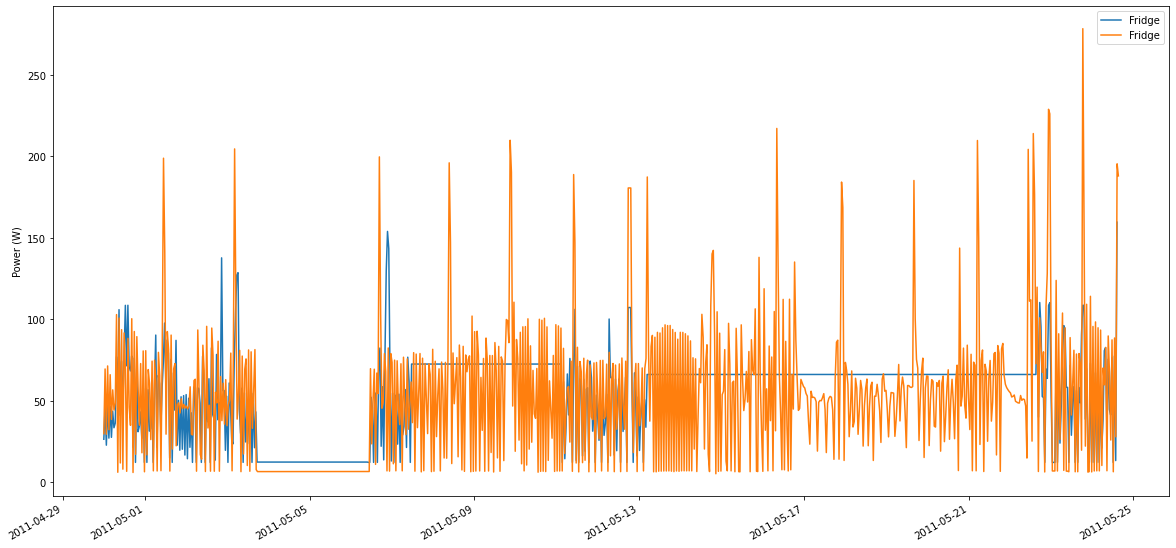

In [6]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
predicted.plot()
ground_truth.plot()
plt.show()

In [9]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

def recall_precision_accuracy_f1(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    threshold = ground.on_power_threshold()
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        sum_samples += len(chunk)
        pr = np.array([0 if (p)<threshold else 1 for p in chunk.iloc[:,0]])
        gr = np.array([0 if p<threshold else 1 for p in chunk.iloc[:,1]])

        tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)
        p = sum(pr)
        n = len(pr) - p

        chunk_results.append([tp,tn,fp,fn,p,n])

    if sum_samples == 0:
        return None
    else:
        [tp,tn,fp,fn,p,n] = np.sum(chunk_results, axis=0)

        res_recall = recall(tp,fn)
        res_precision = precision(tp,fp)
        res_f1 = f1(res_precision,res_recall)
        res_accuracy = accuracy(tp,tn,p,n)

        return (res_recall,res_precision,res_accuracy,res_f1)

def relative_error_total_energy(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        E_pred = sum(chunk.iloc[:,0])
        E_ground = sum(chunk.iloc[:,1])

        chunk_results.append([
                            E_pred,
                            E_ground
                            ])
    if sum_samples == 0:
        return None
    else:
        [E_pred, E_ground] = np.sum(chunk_results,axis=0)
        return abs(E_pred - E_ground) / float(max(E_pred,E_ground))

def mean_absolute_error(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    total_sum = 0.0
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        total_sum += sum(abs((chunk.iloc[:,0]) - chunk.iloc[:,1]))
    if sum_samples == 0:
        return None
    else:
        return total_sum / sum_samples


def recall(tp,fn):
    return tp/float(tp+fn)

def precision(tp,fp):
    return tp/float(tp+fp)

def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)

def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)


In [11]:

rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.9998505035538627
============ Precision: 0.8068661185961065
============ Accuracy: 0.8067757810992215
============ F1 Score: 0.8930515002611215
============ Relative error in total energy: 0.7003656557830958
============ Mean absolute error(in Watts): 44.570944966737216
